In [11]:
import yfinance as yf
import numpy as np
import pandas as pd
import pickle
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, mean_absolute_percentage_error
from xgboost import XGBRegressor

In [12]:
ticker = "AAPL"
interval = "1m"
# trading days are monday to friday. Used 15 days or half monthly daily 1 minute interval trading data, to check current situation and latest trend in the stock market
s_date_1, e_date_1 = "2025-12-29", "2026-01-02"
s_date_2, e_date_2 = "2026-01-05", "2026-01-09"
s_date_3, e_date_3 = "2026-01-12", "2026-01-14"

d_7d_1 = yf.download(ticker, start=s_date_1, end=e_date_1, interval=interval)[["Close"]].dropna()
d_7d_2 = yf.download(ticker, start=s_date_2, end=e_date_2, interval=interval)[["Close"]].dropna()
d_7d_3 = yf.download(ticker, start=s_date_3, end=e_date_3, interval=interval)[["Close"]].dropna()

data_com = pd.concat([d_7d_1, d_7d_2, d_7d_3]).dropna()
close = data_com["Close"].values.astype(float)

/tmp/ipython-input-4212768214.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  d_7d_1 = yf.download(ticker, start=s_date_1, end=e_date_1, interval=interval)[["Close"]].dropna()
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-4212768214.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  d_7d_2 = yf.download(ticker, start=s_date_2, end=e_date_2, interval=interval)[["Close"]].dropna()
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-4212768214.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  d_7d_3 = yf.download(ticker, start=s_date_3, end=e_date_3, interval=interval)[["Close"]].dropna()
[*********************100%***********************]  1 of 1 completed


In [13]:
seq_len = 60
# target and features are taken as 60 lagged based to study aapl stock trend in a lagged manner
def make_lag_features(series_1d, seq_len=60):
    X, y = [], []
    for i in range(len(series_1d) - seq_len):
        X.append(series_1d[i:i+seq_len])
        y.append(series_1d[i+seq_len])       # next value
    return np.asarray(X), np.asarray(y)

X_all, y_all = make_lag_features(close, seq_len=seq_len)

In [14]:
# .80-.20 split
split = int(len(X_all) * 0.8)
X_train, X_test = X_all[:split], X_all[split:]
y_train, y_test = y_all[:split], y_all[split:]

In [15]:

svr_pipe = Pipeline([
    ("x_scaler", MinMaxScaler()),
    ("svr", SVR(kernel="rbf"))
])
svr_model = TransformedTargetRegressor(
    regressor=svr_pipe,
    transformer=MinMaxScaler()
)
rf_model = Pipeline([
    ("rf", RandomForestRegressor(random_state=42, n_jobs=-1))
])
xgb_model = Pipeline([
    ("xgb", XGBRegressor(
        random_state=42,
        n_jobs=-1,
        objective="reg:squarederror",
        tree_method="hist"
    ))
])

In [16]:
tscv = TimeSeriesSplit(n_splits=5)

scoring = "neg_root_mean_squared_error"

searches = {
    "SVR": RandomizedSearchCV(
        estimator=svr_model,
        param_distributions={
            "regressor__svr__C": [0.5, 1, 2, 5, 10, 20],
            "regressor__svr__epsilon": [0.001, 0.01, 0.05, 0.1, 0.2],
            "regressor__svr__gamma": ["scale", "auto"]
        },
        n_iter=25,
        cv=tscv,
        scoring=scoring,
        random_state=42,
        n_jobs=-1,
        verbose=0
    ),

    "Random Forest": RandomizedSearchCV(
        estimator=rf_model,
        param_distributions={
            "rf__n_estimators": [100, 150, 200, 250],
            "rf__max_depth": [x for x in range(10,90, 10)],
            "rf__min_samples_split": [x for x in range(2,10)],
            "rf__min_samples_leaf": [x for x in range(2,10)],
            "rf__max_features": ["sqrt", "log2", None],
        },
        n_iter=25,
        cv=tscv,
        scoring=scoring,
        random_state=42,
        n_jobs=-1,
        verbose=0
    ),

    "XGBoost": RandomizedSearchCV(
        estimator=xgb_model,
        param_distributions={
            "xgb__n_estimators": [x for x in range(50,300, 25)],
            "xgb__learning_rate": [0.01, 0.03, 0.05, 0.1],
            "xgb__max_depth": [x for x in range(10,90, 10)],
            "xgb__subsample": [0.6, 0.8, 1.0],
            "xgb__colsample_bytree": [0.6, 0.8, 1.0],
            "xgb__reg_lambda": [0.5, 1.0, 2.0, 5.0],
            "xgb__min_child_weight": [1, 3, 5]
        },
        n_iter=30,
        cv=tscv,
        scoring=scoring,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )
}

In [17]:

rows = []
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)
for name, search in searches.items():
    search.fit(X_train_reshaped, y_train)
    best = search.best_estimator_
    pred = best.predict(X_test_reshaped)
    mae = mean_absolute_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    r2 = r2_score(y_test, pred)
    mape = mean_absolute_percentage_error(y_test, pred)
    cv_rmse_mean = -search.best_score_
    cv_rmse_std = search.cv_results_["std_test_score"][search.best_index_]
    rows.append({
        "Model": name,
        "CV_RMSE_mean": cv_rmse_mean,
        "CV_RMSE_std": cv_rmse_std,
        "Test_MAE": mae,
        "Test_RMSE": rmse,
        "Test_R2": r2,
        "Test_MAPE": mape,
        "Best_Params": search.best_params_
    })

results_df = pd.DataFrame(rows).sort_values("Test_RMSE").reset_index(drop=True)
results_df

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


,Model,CV_RMSE_mean,CV_RMSE_std,Test_MAE,Test_RMSE,Test_R2,Test_MAPE,Best_Params
0,SVR,1.178018,0.992980,0.095293,0.137110,0.941749,0.000366,"{'regressor__svr__gamma': 'auto', 'regressor__..."
1,XGBoost,1.943850,1.082959,0.431289,0.525353,0.144800,0.001656,"{'xgb__subsample': 1.0, 'xgb__reg_lambda': 0.5..."
2,Random Forest,1.887549,1.061736,0.503957,0.569884,-0.006326,0.001934,"{'rf__n_estimators': 250, 'rf__min_samples_spl..."


In [18]:
best_name = results_df.loc[0, "Model"]
best_search = searches[best_name]
# fiting the best model
best_search.fit(X_train_reshaped, y_train)
best_model = best_search.best_estimator_

pred = best_model.predict(X_test_reshaped)

# evalution metrics
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)

mape = mean_absolute_percentage_error(y_test, pred) * 100

print(f"Best model: {best_name}")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2:   {r2:.4f}")
print(f"MAPE: {mape:.2f}%")
print("\nBest Params:")
print(best_search.best_params_)

Best model: SVR
MAE:  0.0953
RMSE: 0.1371
R2:   0.9417
MAPE: 0.04%

Best Params:
{'regressor__svr__gamma': 'auto', 'regressor__svr__epsilon': 0.01, 'regressor__svr__C': 10}


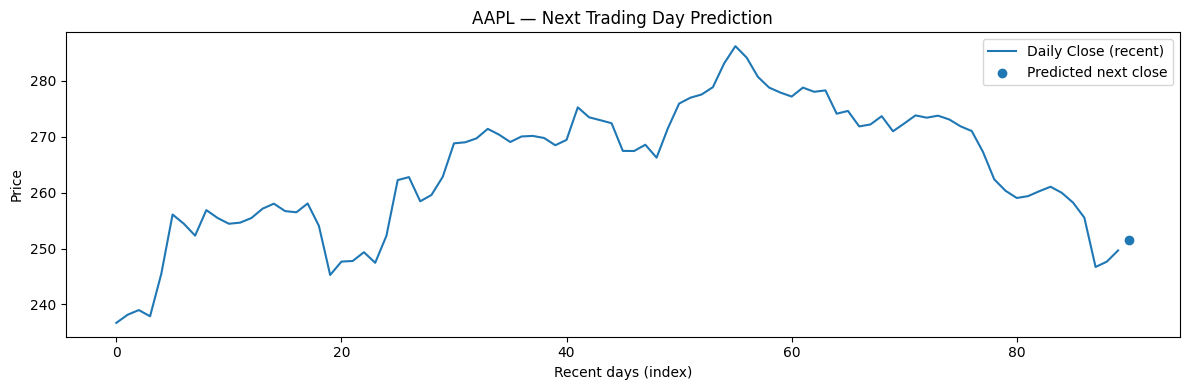

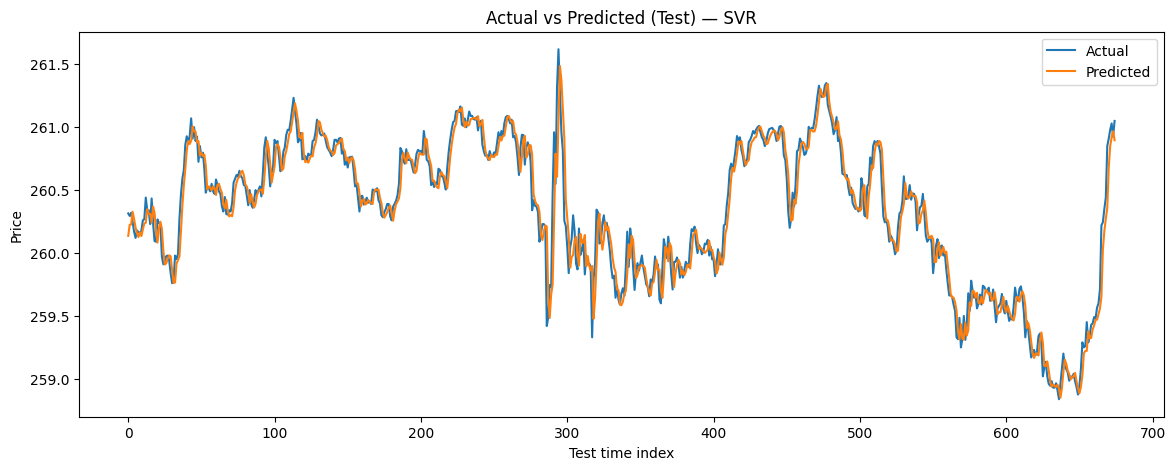

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 5))
plt.plot(y_test, label="Actual")
plt.plot(pred, label="Predicted")
plt.title(f"Actual vs Predicted (Test) — {best_name}")
plt.xlabel("Test time index")
plt.ylabel("Price")
plt.legend()
plt.show()

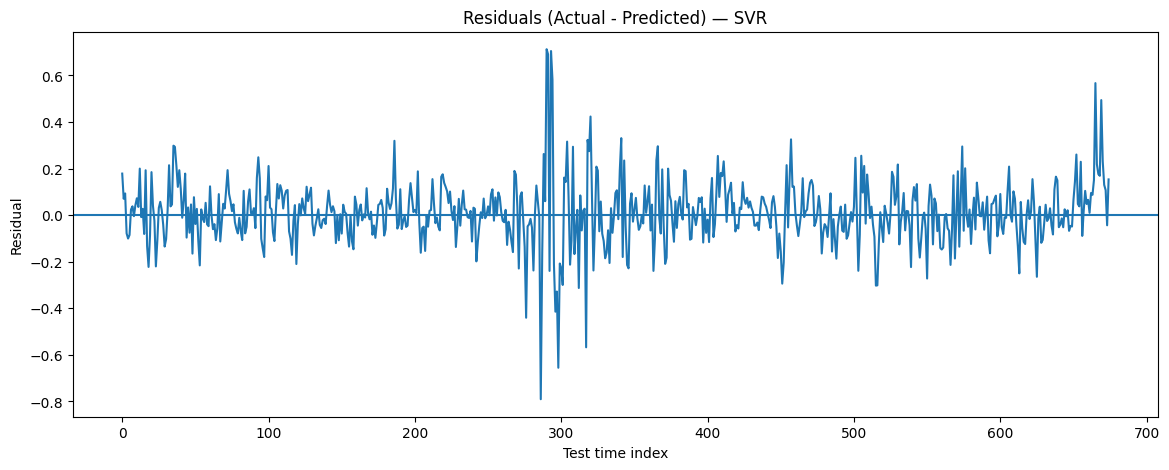

In [20]:
residuals = y_test - pred

plt.figure(figsize=(14, 5))
plt.plot(residuals)
plt.title(f"Residuals (Actual - Predicted) — {best_name}")
plt.xlabel("Test time index")
plt.ylabel("Residual")
plt.axhline(0)
plt.show()

In [21]:
model_filename = "best_price_model.pkl"

with open(model_filename, "wb") as f:
    pickle.dump(best_model, f)




In [23]:
import gradio as gr
import pandas as pd
import pickle
import numpy as np
import yfinance as yf

with open("best_price_model.pkl", "rb") as f:
    model = pickle.load(f)

SEQ_LEN = 60  # lag lenght
def predict_next_day_price():
    # download latest daily AAPL data
    df = yf.download(
        "AAPL",
        period="1y",
        interval="1d",
        progress=False
    )

    df = df[["Close"]].dropna()
    last_price = float(df["Close"].iloc[-1])
    # prepare input features of last 60 day that is downloaded
    X_input = df["Close"].iloc[-SEQ_LEN:].values.reshape(1, -1)
    # predict next day price
    prediction = float(model.predict(X_input)[0])
    # difference calculation
    change = prediction - last_price
    pct_change = (change / last_price) * 100

    return (
        f"Apple (AAPL) Next-Day Prediction\n\n"
        f"Last Close Price: ${last_price:.2f}\n"
        f"Predicted Next-Day Close: ${prediction:.2f}\n"
        f"Expected Change: {change:+.2f} ({pct_change:+.2f}%)"
    )

inputs = []

app = gr.Interface(
    fn=predict_next_day_price,
    inputs=inputs,
    outputs=gr.Textbox(lines=8, label="Prediction Result"),
    title="AAPL Next-Day Stock Price Predictor",
    description="Click Predict to fetch the latest Apple stock price and predict the next trading day's closing price."
)


app.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://da576d0280c5843234.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
